# Visualize pymoo result
Load the pymoo result object saved with pickle and visualize it.

ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [1]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj3: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

## Load result from 13 algorithms
Place a pymoo result object file saved with pickle and execute the following cell.

In [2]:
with open('res_bc_Abvt_agemoea.pkl','rb') as f1:
    res_1 = pickle.load(f1)
with open('res_bc_Abvt_agemoea2.pkl','rb') as f2:
    res_2 = pickle.load(f2)
with open('res_bc_Abvt_nsga2.pkl','rb') as f3:
    res_3 = pickle.load(f3)
with open('res_bc_Abvt_nsga3.pkl','rb') as f4:
    res_4 = pickle.load(f4)
with open('res_bc_Abvt_rnsga2.pkl','rb') as f5:
    res_5 = pickle.load(f5)
with open('res_bc_Abvt_rnsga3.pkl','rb') as f6:
    res_6 = pickle.load(f6)
with open('res_bc_Abvt_rvea.pkl','rb') as f7:
    res_7 = pickle.load(f7)
with open('res_bc_Abvt_smsemoa.pkl','rb') as f8:
    res_8 = pickle.load(f8)
with open('res_bc_Abvt_unsga3.pkl','rb') as f9:
    res_9 = pickle.load(f9)

In [3]:
with open('res_bc_Abvt_ctaea.pkl','rb') as f10:
    res_10 = pickle.load(f10)
with open('res_bc_Abvt_dnsga2.pkl','rb') as f11:
    res_11 = pickle.load(f11)
with open('res_bc_Abvt_kgbdmoea.pkl','rb') as f12:
    res_12 = pickle.load(f12)
with open('res_bc_Abvt_moead.pkl','rb') as f13:
    res_13 = pickle.load(f13)

## Hypervolume
Hypervolume is used to check the convergence.

In [4]:
import matplotlib.pyplot as plt
from pymoo.indicators.hv import Hypervolume

F1=res_1.F
F2=res_2.F
F3=res_3.F
F4=res_4.F
F5=res_5.F
F6=res_6.F
F7=res_7.F
F8=res_8.F
F9=res_9.F

# # Nadir Point from 9 Algorithms: 
# ref_point = [1.81000000e+02 6.20000000e+01 3.92281875e+03 1.70537209e+00]
# # Nadir Point from 4 Algorithms: 
# ref_point = [160.  77.  inf  inf]
# # Nadir Point from all (13) Algorithms: 
# ref_point = [181.  77.  inf  inf]

ref_point = [181, 77, 3922.81875, 1.70537209]

hist_F1 = []
hist_F2 = []
hist_F3 = []
hist_F4 = []
hist_F5 = []
hist_F6 = []
hist_F7 = []
hist_F8 = []
hist_F9 = []

for algo1 in res_1.history:
    opt1 = algo1.opt
    feas1 = np.where(opt1.get("feasible"))[0]
    hist_F1.append(opt1.get("F")[feas1])
for algo2 in res_2.history:
    opt2 = algo2.opt
    feas2 = np.where(opt2.get("feasible"))[0]
    hist_F2.append(opt2.get("F")[feas2])
for algo3 in res_3.history:
    opt3 = algo3.opt
    feas3 = np.where(opt3.get("feasible"))[0]
    hist_F3.append(opt3.get("F")[feas3])
for algo4 in res_4.history:
    opt4 = algo4.opt
    feas4 = np.where(opt4.get("feasible"))[0]
    hist_F4.append(opt4.get("F")[feas4])
for algo5 in res_5.history:
    opt5 = algo5.opt
    feas5 = np.where(opt5.get("feasible"))[0]
    hist_F5.append(opt5.get("F")[feas5])
for algo6 in res_6.history:
    opt6 = algo6.opt
    feas6 = np.where(opt6.get("feasible"))[0]
    hist_F6.append(opt6.get("F")[feas6])
for algo7 in res_7.history:
    opt7 = algo7.opt
    feas7 = np.where(opt7.get("feasible"))[0]
    hist_F7.append(opt7.get("F")[feas7])
for algo8 in res_8.history:
    opt8 = algo8.opt
    feas8 = np.where(opt8.get("feasible"))[0]
    hist_F8.append(opt8.get("F")[feas8])
for algo9 in res_9.history:
    opt9 = algo9.opt
    feas9 = np.where(opt9.get("feasible"))[0]
    hist_F9.append(opt9.get("F")[feas9])


# approx_ideal_1 = F1.min(axis=0)
# approx_nadir_1 = F1.max(axis=0)
# approx_ideal_2 = F2.min(axis=0)
# approx_nadir_2 = F2.max(axis=0)
# approx_ideal_3 = F3.min(axis=0)
# approx_nadir_3 = F3.max(axis=0)
# approx_ideal_4 = F4.min(axis=0)
# approx_nadir_4 = F4.max(axis=0)
# approx_ideal_5 = F5.min(axis=0)
# approx_nadir_5 = F5.max(axis=0)
# approx_ideal_6 = F6.min(axis=0)
# approx_nadir_6 = F6.max(axis=0)
# approx_ideal_7 = F7.min(axis=0)
# approx_nadir_7 = F7.max(axis=0)
# approx_ideal_8 = F8.min(axis=0)
# approx_nadir_8 = F8.max(axis=0)
# approx_ideal_9 = F9.min(axis=0)
# approx_nadir_9 = F9.max(axis=0)


# metric_1 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_1,
#                      nadir=approx_nadir_1)
# metric_2 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_2,
#                      nadir=approx_nadir_2)
# metric_3 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_3,
#                      nadir=approx_nadir_3)
# metric_4 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_4,
#                      nadir=approx_nadir_4)
# metric_5 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_5,
#                      nadir=approx_nadir_5)
# metric_6 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_6,
#                      nadir=approx_nadir_6)
# metric_7 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_7,
#                      nadir=approx_nadir_7)
# metric_8 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_8,
#                      nadir=approx_nadir_8)
# metric_9 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_9,
#                      nadir=approx_nadir_9)
metric_1 = Hypervolume(ref_point= np.array(ref_point))

hv_1 = [metric_1.do(_F1) for _F1 in hist_F1]
hv_2 = [metric_1.do(_F2) for _F2 in hist_F2]
hv_3 = [metric_1.do(_F3) for _F3 in hist_F3]
hv_4 = [metric_1.do(_F4) for _F4 in hist_F4]
hv_5 = [metric_1.do(_F5) for _F5 in hist_F5]
hv_6 = [metric_1.do(_F6) for _F6 in hist_F6]
hv_7 = [metric_1.do(_F7) for _F7 in hist_F7]
hv_8 = [metric_1.do(_F8) for _F8 in hist_F8]
hv_9 = [metric_1.do(_F9) for _F9 in hist_F9]

# hv_1 = [metric_1.do(_F1) for _F1 in hist_F1[:200]]
# hv_2 = [metric_2.do(_F2) for _F2 in hist_F2[:200]]
# hv_3 = [metric_3.do(_F3) for _F3 in hist_F3[:200]]
# hv_4 = [metric_4.do(_F4) for _F4 in hist_F4[:200]]
# hv_5 = [metric_5.do(_F5) for _F5 in hist_F5[:200]]
# hv_6 = [metric_6.do(_F6) for _F6 in hist_F6[:200]]
# hv_7 = [metric_7.do(_F7) for _F7 in hist_F7[:200]]
# hv_8 = [metric_8.do(_F8) for _F8 in hist_F8[:200]]
# hv_9 = [metric_9.do(_F9) for _F9 in hist_F9[:200]]

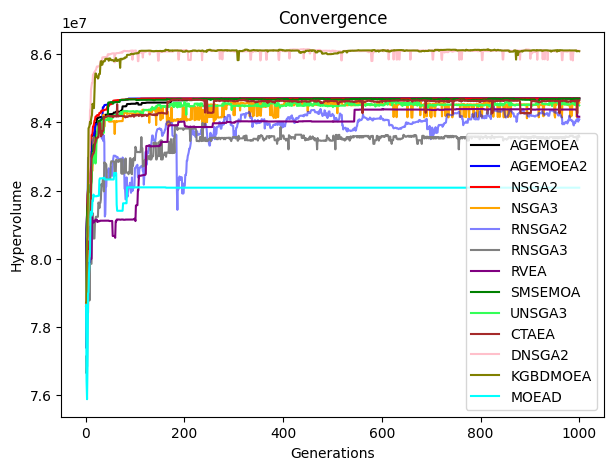

In [5]:
F10=res_10.F
F11=res_11.F
F12=res_12.F
F13=res_13.F

hist_F10 = []
hist_F11 = []
hist_F12 = []
hist_F13 = []

for algo10 in res_10.history:
    opt10 = algo10.opt
    feas10 = np.where(opt10.get("feasible"))[0]
    hist_F10.append(opt10.get("F")[feas10])
for algo11 in res_11.history:
    opt11 = algo11.opt
    feas11 = np.where(opt11.get("feasible"))[0]
    hist_F11.append(opt11.get("F")[feas11])
for algo12 in res_12.history:
    opt12 = algo12.opt
    feas12 = np.where(opt12.get("feasible"))[0]
    hist_F12.append(opt12.get("F")[feas12])
for algo13 in res_13.history:
    opt13 = algo13.opt
    feas13 = np.where(opt13.get("feasible"))[0]
    hist_F13.append(opt13.get("F")[feas13])

# approx_ideal_10 = F10.min(axis=0)
# approx_nadir_10 = F10.max(axis=0)
# approx_ideal_11 = F11.min(axis=0)
# approx_nadir_11 = F11.max(axis=0)
# approx_ideal_12 = F12.min(axis=0)
# approx_nadir_12 = F12.max(axis=0)
# approx_ideal_13 = F13.min(axis=0)
# approx_nadir_13 = F13.max(axis=0)


# metric_10 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_1,
#                      nadir=approx_nadir_1)
# metric_11 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_1,
#                      nadir=approx_nadir_1)
# metric_12 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_1,
#                      nadir=approx_nadir_1)
# metric_13 = Hypervolume(ref_point= np.array(ref_point),
#                      zero_to_one=True,
#                      ideal=approx_ideal_13,
#                      nadir=approx_nadir_13)

hv_10 = [metric_1.do(_F10) for _F10 in hist_F10]
hv_11 = [metric_1.do(_F11) for _F11 in hist_F11]
hv_12 = [metric_1.do(_F12) for _F12 in hist_F12]
hv_13 = [metric_1.do(_F13) for _F13 in hist_F13]

# hv_10 = [metric_10.do(_F10) for _F10 in hist_F10[:200]]
# hv_11 = [metric_11.do(_F11) for _F11 in hist_F11[:200]]
# hv_12 = [metric_12.do(_F12) for _F12 in hist_F12[:200]]
# hv_13 = [metric_13.do(_F13) for _F13 in hist_F13[:200]]

#  Show all alogrithms' hv into a single figure
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_1)+1)), hv_1,  color='black', label='AGEMOEA')
plt.plot(list(range(1, len(hv_2)+1)), hv_2,  color='blue', label='AGEMOEA2')
plt.plot(list(range(1, len(hv_3)+1)), hv_3,  color='red', label='NSGA2')
plt.plot(list(range(1, len(hv_4)+1)), hv_4,  color='orange', label='NSGA3')
plt.plot(list(range(1, len(hv_5)+1)), hv_5,  color=(0, 0, 1, 0.5), label='RNSGA2')
plt.plot(list(range(1, len(hv_6)+1)), hv_6,  color='gray', label='RNSGA3')
plt.plot(list(range(1, len(hv_7)+1)), hv_7,  color='purple', label='RVEA')
plt.plot(list(range(1, len(hv_8)+1)), hv_8,  color='green', label='SMSEMOA')
plt.plot(list(range(1, len(hv_9)+1)), hv_9,  color='#33FF57', label='UNSGA3')
plt.plot(list(range(1, len(hv_10)+1)), hv_10,  color='brown', label='CTAEA')
plt.plot(list(range(1, len(hv_11)+1)), hv_11,  color='pink', label='DNSGA2')
plt.plot(list(range(1, len(hv_12)+1)), hv_12,  color='olive', label='KGBDMOEA')
plt.plot(list(range(1, len(hv_13)+1)), hv_13,  color='cyan', label='MOEAD')
plt.title("Convergence")
plt.xlabel("Generations") # brown,pink,#5733FF,olive,cyan,#FF5733,#33FF57
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

### The below figure only shows 'CTAEA' and 'MOEAD'
'CTAEA' (could not pre-define the input as the binary value), 'MOEAD' (could not set up the evaluating constrains)
- Their hv too high but not enough generations.

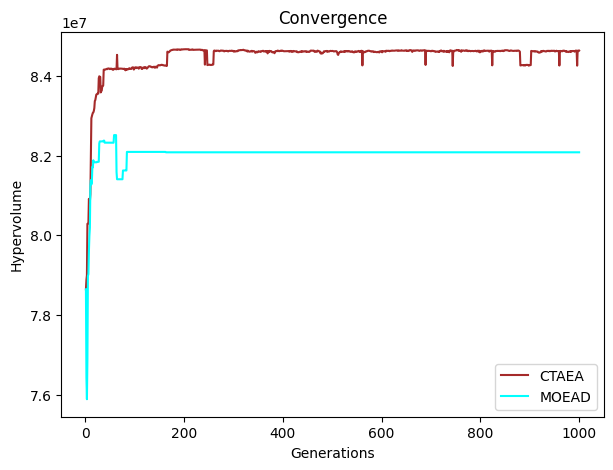

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_10)+1)), hv_10,  color='brown', label='CTAEA')
plt.plot(list(range(1, len(hv_13)+1)), hv_13,  color='cyan', label='MOEAD')
plt.title("Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

### The below figure only shows 'DNSGA2' and 'KGBDMOEA'
Both of them could not set up the evaluating constrains.
- their hv too low.
- 'DNSGA2': hv is always 0
- 'KGBDMOEA': hv is always 0

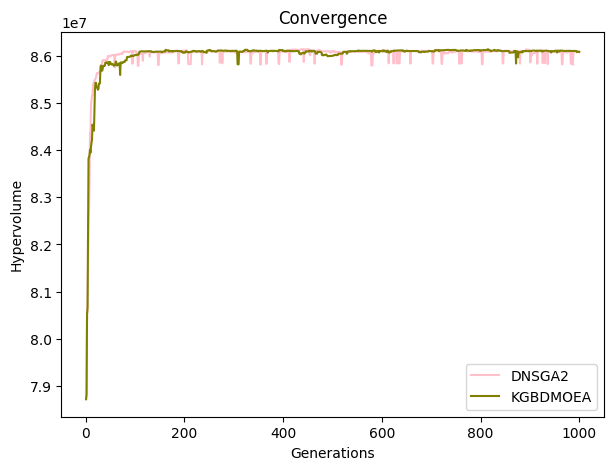

In [7]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_11)+1)), hv_11,  color='pink', label='DNSGA2')
plt.plot(list(range(1, len(hv_12)+1)), hv_12,  color='olive', label='KGBDMOEA')
plt.title("Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

### The below figure only shows 'RNSGA2' and 'RNSGA3'
For a clearer view (their hv too high for the rest algorithms).

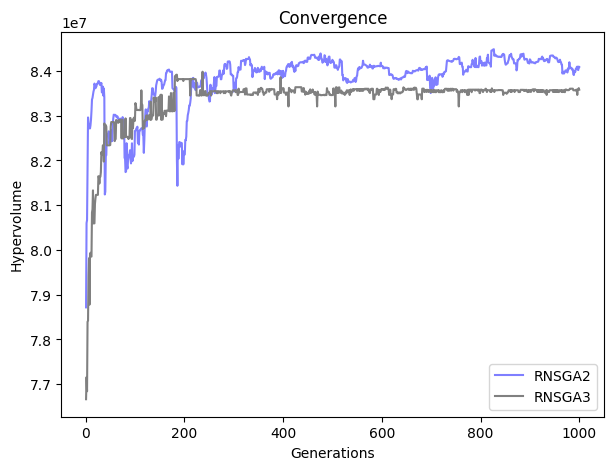

In [8]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_5)+1)), hv_5,  color=(0, 0, 1, 0.5), label='RNSGA2')
plt.plot(list(range(1, len(hv_6)+1)), hv_6,  color='gray', label='RNSGA3')
plt.title("Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

### The below figure shows the rest of algorithms, including:
'AGEMOEA', 'AGEMOEA2', 'NSGA2', 'NSGA3', 'RVEA', 'SMSEMOA', and 'UNSGA3'.

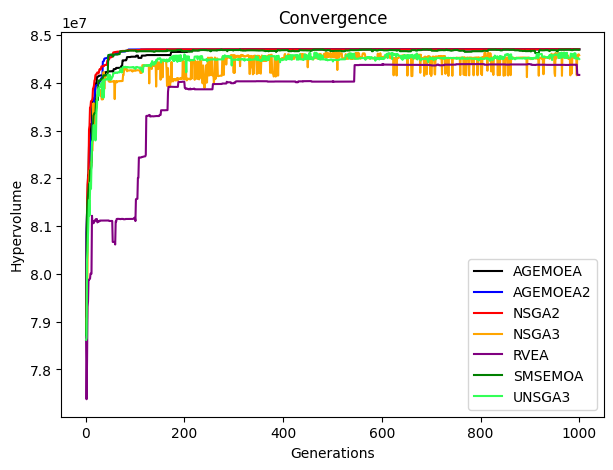

In [9]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_1)+1)), hv_1,  color='black', label='AGEMOEA')
plt.plot(list(range(1, len(hv_2)+1)), hv_2,  color='blue', label='AGEMOEA2')
plt.plot(list(range(1, len(hv_3)+1)), hv_3,  color='red', label='NSGA2')
plt.plot(list(range(1, len(hv_4)+1)), hv_4,  color='orange', label='NSGA3')
plt.plot(list(range(1, len(hv_7)+1)), hv_7,  color='purple', label='RVEA')
plt.plot(list(range(1, len(hv_8)+1)), hv_8,  color='green', label='SMSEMOA')
plt.plot(list(range(1, len(hv_9)+1)), hv_9,  color='#33FF57', label='UNSGA3')
plt.title("Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

## Test

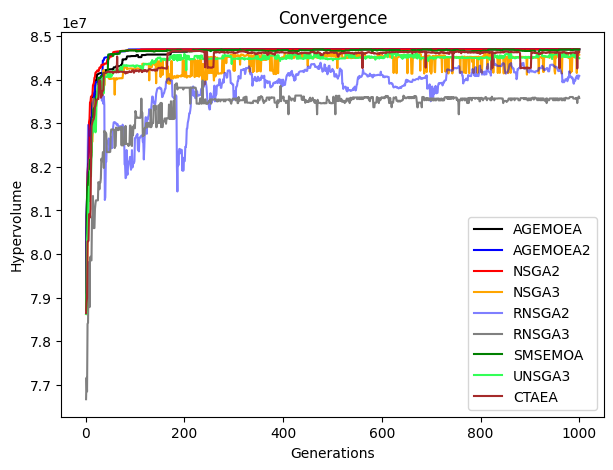

In [11]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_1)+1)), hv_1,  color='black', label='AGEMOEA')
plt.plot(list(range(1, len(hv_2)+1)), hv_2,  color='blue', label='AGEMOEA2')
plt.plot(list(range(1, len(hv_3)+1)), hv_3,  color='red', label='NSGA2')
plt.plot(list(range(1, len(hv_4)+1)), hv_4,  color='orange', label='NSGA3')
plt.plot(list(range(1, len(hv_5)+1)), hv_5,  color=(0, 0, 1, 0.5), label='RNSGA2')
plt.plot(list(range(1, len(hv_6)+1)), hv_6,  color='gray', label='RNSGA3')
# plt.plot(list(range(1, len(hv_7)+1)), hv_7,  color='purple', label='RVEA')
plt.plot(list(range(1, len(hv_8)+1)), hv_8,  color='green', label='SMSEMOA')
plt.plot(list(range(1, len(hv_9)+1)), hv_9,  color='#33FF57', label='UNSGA3')
plt.plot(list(range(1, len(hv_10)+1)), hv_10,  color='brown', label='CTAEA')
# plt.plot(list(range(1, len(hv_11)+1)), hv_11,  color='pink', label='DNSGA2')
# plt.plot(list(range(1, len(hv_12)+1)), hv_12,  color='olive', label='KGBDMOEA')
# plt.plot(list(range(1, len(hv_13)+1)), hv_13,  color='cyan', label='MOEAD')
plt.title("Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()